## Table of Contents

I. [The Problem](#the_problem)

II. [Results Summary](#results_summary)

III. [Data Analysis](#the_data)

IV. [Appendix](#appendix)

<a id='the_problem'></a>
**I. Problem**

I want to find some insight into the drop in user engagement. After the week beginning July 28, 2014, there is a drop in total unique users who engage with Yammer. User engagement continues to fall until the end of our data (the week beginning August 25).

<a id='results_summary'></a>
**II. Results Summary**

Some results:
* In addition to unique active users decreasing, total event engagements by week are decreasing
* People are still signing up for the service
* Only 63% of users who signed up have engaged with the service otherwise leaving 37% who have not
* Most users only use the service a few times
* The drops that were the largest compared to the total engagements at the first date were home_page, like_message, and view_inbox 

However, I have not found any evidence of what has caused the drop in engagement. I explore the above results in the Data Analysis section.

<a id='the_data'></a>
**III. Data Analysis**

First, we import some necessary python libraries and import our datasets as pandas dataframes.

In [1]:
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import datetime

df_users = pd.read_csv('yammer_users.csv')
df_events = pd.read_csv('yammer_events.csv')
df_emails = pd.read_csv('yammer_emails.csv')
df_periods = pd.read_csv('dimension_rollup_periods.csv')

Now we convert the event dates to a datetime format

In [2]:
df_events.occurred_at = pd.to_datetime(df_events.occurred_at)

In order to replicate the graph that concerned my boss, I need to map each event date to the week in which it occurred. I do this by finding the weeks that I want to consider and writing a function that sends each date to the first date of the week.

In [3]:
weeks = df_periods[df_periods.period_id == 1007].copy() # looks at all 1 week periods
weeks.pst_start = pd.to_datetime(weeks.pst_start) # convert string to datetime
weeks.pst_end = pd.to_datetime(weeks.pst_end) # convert string to datetime
startdate = weeks.pst_start.iloc[489] # The first date we are considering
week_lst = []
for n in range(18):
    week_lst.append(startdate + n*datetime.timedelta(days=7)) # Make a list of all the dates we are considering

In [6]:
def whichweek(date,weeklist): # given a date in our time frame, returns the first date of the week
    for i in range(len(weeklist)):
        if date < weeklist[i]:
            return weeklist[i-1] 
    else: 
        return weeklist[-1]

In [7]:
df_events['weekstart'] = df_events.occurred_at.apply(lambda x: whichweek(x,week_lst)) 
# map our dates to the first of the week

The plot of active users per week, as given to me by my boss is:

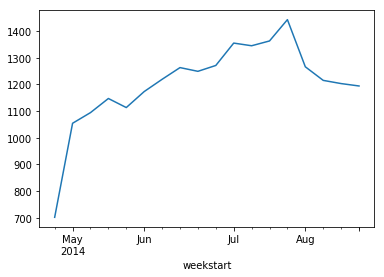

In [8]:
(df_events[df_events.event_type == 'engagement'].groupby('weekstart')['user_id'].nunique()).plot(kind = 'line')

Notice that there is a peak in the number of active users in the week of July 28 and then it drops through this week that just ended (week starting August 25).

I would like to be able to explain this. I can plot the number of engagement events by week.

In [9]:
engagement_by_week = df_events[df_events.event_type == 'engagement'].groupby('weekstart').size()

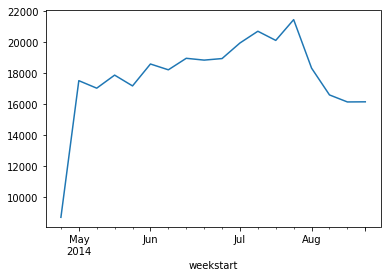

In [10]:
engagement_by_week.plot(kind='line')

We see that the number of engagement events is also dropping.

Let us see how many users are signing up each week.

In [11]:
signups_by_week = df_events[df_events.event_type == 'signup_flow'].groupby('weekstart').size()

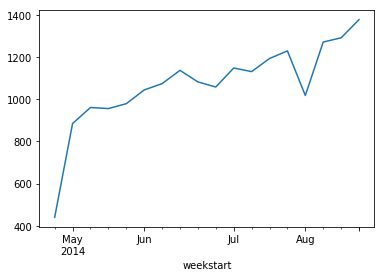

In [12]:
signups_by_week.plot(kind='line')

Signups are increasing (with a dip).

The percent of users who have signed up AND engaged with the service is

In [13]:
round(df_events[df_events.event_type == 'engagement'].user_id.unique().shape[0]/df_events.user_id.unique().shape[0], 3)

0.629

So, about 37% of users have signed up but not engaged.

In [14]:
df_engagement = df_events.copy()[df_events.event_type == 'engagement']

Now I consider how many engagement events there are per user and plot them on a histogram.

In [15]:
user_engagements = df_engagement.groupby('user_id').size()

(array([4.675e+03, 8.270e+02, 3.140e+02, 1.670e+02, 9.300e+01, 3.000e+01,
        2.300e+01, 1.000e+01, 2.000e+00, 1.000e+00]),
 array([  2. ,  65.8, 129.6, 193.4, 257.2, 321. , 384.8, 448.6, 512.4,
        576.2, 640. ]),
 <a list of 10 Patch objects>)

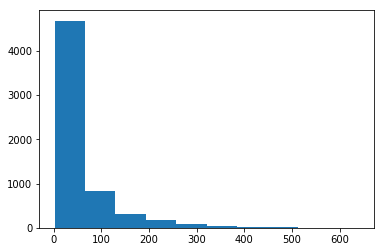

In [16]:
plt.hist(user_engagements)

So, most users by far only engage a few times.

Engagement events on July 28 are in EN1 and the engagement events for August 25 are in EN2:

In [17]:
EN1 = df_engagement[df_engagement.weekstart == '2014-07-28T00:00:00.000000000'].groupby('event_name').size()
EN2 = df_engagement[df_engagement.weekstart == '2014-08-25T00:00:00.000000000'].groupby('event_name').size()

Now we can compare the change from July 28 to August 25 to the number of events in July 28 by the event name.

In [18]:
(EN1 - EN2)/sum(EN1)

event_name
home_page                 0.071209
like_message              0.048715
login                     0.023798
search_autocomplete       0.006520
search_click_result_1     0.001397
search_click_result_10    0.001071
search_click_result_2     0.001630
search_click_result_3     0.001444
search_click_result_4     0.000931
search_click_result_5     0.000978
search_click_result_6     0.001257
search_click_result_7     0.001071
search_click_result_8     0.000559
search_click_result_9     0.001164
search_run                0.014531
send_message              0.028642
view_inbox                0.042194
dtype: float64

The sum of all the search clicks is 0.011502

So, The drops that were the largest compared to the total engagements at the first date were home_page, like_message, and view_inbox.

<a id='appendix'></a>
**IV. Appendix**

Tested ideas that didn't go anywhere and I didn't include here:
* Did one country lead to a lot of the drop?

Untested ideas:
* Are the most frequent users a cause of the drop?
* Something with the e-mails?
* Do people engage more when they fist sign up?

We can look at which users have engaged the most.

In [19]:
engage_by_user = df_events[df_events.event_type == 'engagement'].groupby('user_id').size()

In [20]:
engage_by_user.sort_values(ascending = False).head(20)

user_id
3390.0     640
10276.0    561
3774.0     525
10498.0    512
2419.0     502
5633.0     500
8733.0     492
3720.0     487
12389.0    473
2398.0     461
7510.0     460
11906.0    455
6074.0     453
12670.0    439
8258.0     437
4626.0     434
12995.0    433
13247.0    433
2940.0     431
12034.0    427
dtype: int64